In [1]:
import os
import spacy
import pandas as pd
import matplotlib.pyplot as plt
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load("en_core_web_sm")

In [2]:
news_path = os.path.join('..', 'data', 'abcnews-date-text.csv')

news = pd.read_csv(news_path)

# Select the columns to make work easier
headlines = news['headline_text']
dates = news['publish_date']

# For testing on smaller dataset
#headlines = headlines[:50000]
#dates = dates[:50000]

In [10]:
# We're adding the spacy properties and methods to the docs
# created by nlp.pipe
nlp.add_pipe(SpacyTextBlob())

polarity_scores = []

# Calc polarity scores for all headlines
for doc in nlp.pipe(headlines, batch_size=1000):
    for sentence in doc.sents:
        polarity_scores.append(sentence._.sentiment.polarity)

In [8]:
# Merge dates and polarity scores back into a data frame
df = pd.DataFrame(zip(dates, polarity_scores), columns = ('publish_date', 'polarity_score'))

# There are an arbitrary amount of headlines for every date, so we collapse the data into
# individual dates and calculate the mean polarity_score for every date
df = df.groupby('publish_date', as_index=False).mean()

# We need publish_date as a date, not int, since we don't want
# our x-axis to think that (for example) 228 (Feb. 28th) is not immediately before 301 (Mar. 1st) etc 
df['publish_date'] = pd.to_datetime(df['publish_date'], format='%Y%m%d')

# Copy the data frame since we are going to manipulate the polarity_score column to two different versions
weekly = pd.DataFrame.copy(df)
monthly = pd.DataFrame.copy(df)

# Smooth the curves
weekly['polarity_score'] = weekly['polarity_score'].rolling(7).mean()
monthly['polarity_score'] = monthly['polarity_score'].rolling(30).mean()

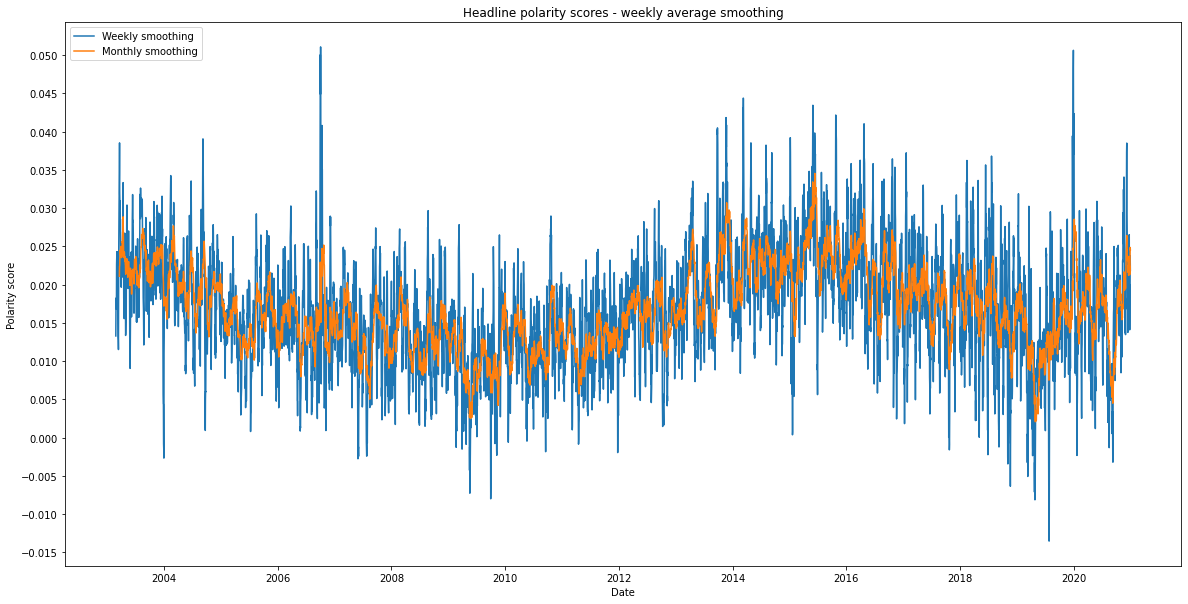

In [9]:
plt.figure(figsize=(20,10)) # Bigger is better
plt.locator_params(axis='y', nbins=20) # more granularity on y-axis

# plot both smoothings and specify labels for the legend
plt.plot(weekly['publish_date'], weekly['polarity_score'], label = 'Weekly smoothing')
plt.plot(monthly['publish_date'], monthly['polarity_score'], label = 'Monthly smoothing')

plt.title('Headline polarity scores - weekly average smoothing')
plt.xlabel('Date')
plt.ylabel('Polarity score')
plt.legend()
plt.show()

## Explanation

__1) What (if any) are the general trends?__

Since the smoothed curves are nearly all in a positive integer value space, we can say that headlines generally convey a positive sentiment, but with a cyclical nature. 

__2) What (if any) inferences might you draw from them?__

There is a very negative period in ~mid-2019 that would be very interesting to look closer at. This is probably too early for covid, but what else might have been different for that year? 

Similarly one could speculate about what happened in the months where there are extremely high (~2007 & ~2020) polarity scores as well as the low points.